# Searching for Images within the PushShift.io Reddit Dataset
See this on [Github](), [NbViewer]()<br>
By Leon Yin 2018-08-14<br>

This notebook should work with all the depencies and the public version of the ProPublica Poltical Ads dataset.

This is a reverse image search that requires two parts -- a pre-trained neural network in PyTorch to convert images into logits, and K-Nearest Neighbors if PyTorch to retrieve logits that are in the proximity of any given input image. The nuance is in re-shaping the data to play well between these two pieces, and allowing new images from the web or from your computer to retrieve results.

Behind the scenes images need to be converted into convolutional features called logits. Logits are learned representations of [shapes, colors and patterns](https://distill.pub/2017/feature-visualization/) that neural networks use to differentiate between different types of images through linear regression. We discard the last step of linear regression, so we just have the logits. The distance between the logits of a new image and all existing images determines the relevance of the image search engine. KNN is used to persist the relationship of between the logits of existing data, and to quickly calcualte the distance of new images.

In [1]:
import os
import json
import copy
import time
import requests
import shutil
from io import BytesIO

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib

import torch
from torch import nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from runtimestamp.runtimestamp import runtimestamp
runtimestamp('Leon')

Updated 2019-04-04 16:49:06.307940
By Leon
Using Python 3.6.5
On Linux-3.10.0-514.10.2.el7.x86_64-x86_64-with-centos-7.3.1611-Core


In [2]:
# this notebook needs version >= 0.4.0
torch.__version__

'1.0.0'

In [3]:
# Are we using a GPU? If not, the device will be using cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
# change this!
subreddit = 'dankmemes'
working_dir = f'/beegfs/work/smapp/reddit_/{subreddit}/'

image_lookup_file = os.path.join(working_dir, 'media.json.gz')

# these files don't exist yet
logits_file = os.path.join(working_dir, 'image_features.csv.gz')
knn_file = os.path.join(working_dir, 'knn.pkl')

# This is where local images are stored
media_dir = os.path.join(working_dir, 'media')

for _dir in [working_dir, media_dir]:
    os.makedirs(_dir, exist_ok=True)

# Feature Extraction <a id='features'></a>
This section will converting raw data that into ML-friendly data. What that means in this context is downloading images and transforming them into logits formatted as PyTorch Tensors.

In [5]:
df = pd.read_json(image_lookup_file, orient='records', 
                  lines=True, compression='gzip')

In [6]:
df = df[~df['d_hash'].isin(['NOHASH', '0000000000000000', 'nan'])] 
len(df)

360372

In [7]:
df.head(2)

,approved_at_utc,archived,author,author_cakeday,author_created_utc,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,...,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,url,view_count,whitelist_status,wls
0,NaN,NaN,mysticbagel14,NaN,NaN,None,None,[],None,None,...,public,top,https://b.thumbs.redditmedia.com/Q5FOgxZX7jWIa...,123.0,140.0,Geddit right,https://i.redd.it/f2qeqwlnatl21.jpg,NaN,all_ads,6.0
1,NaN,NaN,Nathaniel__Bacon,NaN,NaN,,red,[],None,NORMIE,...,public,top,https://b.thumbs.redditmedia.com/6udU2FFGkr3yb...,140.0,140.0,Look how they massacred my boy,https://i.redd.it/514gf53katl21.jpg,NaN,all_ads,6.0


In order to read images into PyTorch, they need to be [Tensors](https://pytorch.org/docs/stable/tensors.html) with standardized dimensions. For images, the dimensions are (width, height, number_of_color_channels, batch_size).

When using models that have already been trained, the new inputs need to resemble the input of the original model. For ResNet50, the input dimensions are (224 x 224 x 3). For most models the last dimension (batch_size) can be adjusted.

torchvision's `transforms` submodule is useful for resizing images, normalizing values and converting the image (which is read into Pillow and NumPy) into a PyTorch tensor.

In [8]:
# The image needs to be specific dimensions, normalized, and converted to a Tensor to be read into a PyTorch model.
scaler = transforms.Resize((224, 224))
to_tensor = transforms.ToTensor()
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# this is the order of operations that will occur on each image.
transformations = transforms.Compose([scaler, 
                                      to_tensor, 
                                      normalizer])

These operations are called within the `read_and_transform_image` function, which can operate on images on disk or on the web:

In [9]:
def read_img(img_file):
    if os.path.exists(img_file):
        # from disk...
        img = Image.open(img_file)
    else:
        # from the web...
        r = requests.get(img_file, stream=True)
        img = Image.open(BytesIO(r.content))
    
    return img

def read_and_transform_image(img_file, transformations=transformations):
    '''This function reads an image into a Pillow object,
    converts it to a PNG, and transforms it into a Torch Tensor'''
    img = read_img(img_file)

    # convert to png
    img = img.convert('RGB')
    
    # transform to tensor
    if transformations is not None:
        img = transformations(img)
    
    return img

Using that handy function, can convert this local image...

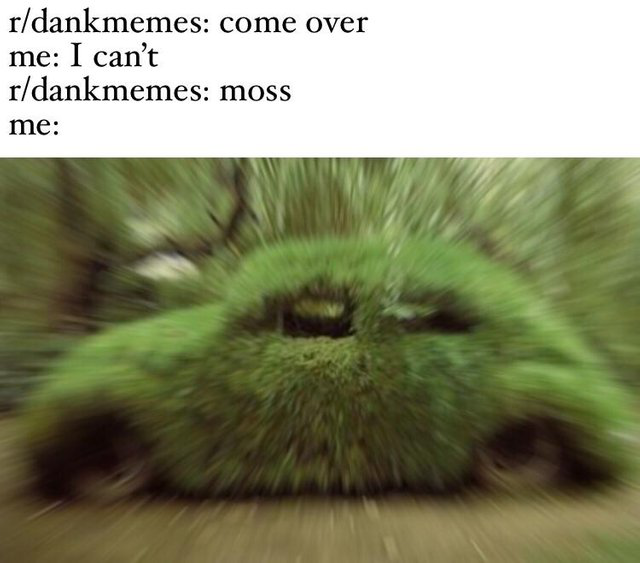

In [10]:
img_file = df.f_img.iloc[0]
read_img(img_file)

into a PyTorch Tensor for ResNet50

In [11]:
read_and_transform_image(img_file, transformations)

tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [-0.6623, -0.6109, -0.6109,  ..., -0.2513, -0.2513, -0.2684],
         [-0.6281, -0.6109, -0.6281,  ..., -0.1828, -0.2342, -0.2684],
         [-0.5938, -0.6281, -0.6452,  ..., -0.1828, -0.2171, -0.2342]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [-0.7927, -0.7402, -0.7227,  ...,  0.1176,  0.1176,  0.1001],
         [-0.7577, -0.7402, -0.7577,  ...,  0.1877,  0.1352,  0.1001],
         [-0.7577, -0.7752, -0.7927,  ...,  0.1877,  0.1527,  0.1352]],

        [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
         [ 2.6400,  2.6400,  2.6400,  ...,  2

But the above is only operating on one image. To efficiently transform many images use [datasets and dataloaders](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Although typically used in training, datasets and dataloaders help parallelize transformations and iterating through the input in batches.

In [12]:
class Feature_Extraction_Dataset(Dataset):
    """Dataset wrapping images and file names
    img_col is the column for the image to be read
    index_col is a unique value to index the extracted features
    """
    def __init__(self, df, img_col, index_col):
        # filter out rows where the file is not on disk.
        self.X_train = df.drop_duplicates(subset='d_hash').reset_index(drop=True)
        self.files = self.X_train[img_col]
        self.idx = self.X_train[index_col]

    def __getitem__(self, index):
        img_idx = self.idx[index]
        img_file = self.files[index]
        try:
            img = read_and_transform_image(self.files[index])
            return img, img_file, img_idx
        except:
            pass

    def __len__(self):
        return len(self.X_train.index)

In [13]:
abd = []
if os.path.exists(logits_file):
    abd = pd.read_csv(logits_file, index_col=0).index.tolist()

In [14]:
dataset = Feature_Extraction_Dataset(df[~df['d_hash'].isin(abd)], 
                                     img_col='f_img', 
                                     index_col='d_hash')
data_loader = DataLoader(dataset,
                         batch_size=64,
                         shuffle=False,
                         num_workers=8)

Next load resNet50 pre-trained on ImageNet.

In [15]:
def load_resnet_for_feature_extraction():
    # Load a pre-trained model
    res50_model = models.resnet50(pretrained=True)

    # Pop the last Dense layer off. This will give us convolutional features.
    res50_conv = nn.Sequential(*list(res50_model.children())[:-1])
    res50_conv.to(device)

    # Don't run backprop!
    for param in res50_conv.parameters():
        param.requires_grad = False

    # we won't be training the model. Instead, we just want predictions so we switch to "eval" mode. 
    res50_conv.eval();
    
    return res50_conv

In [16]:
res50_conv = load_resnet_for_feature_extraction()

Now iterate through the dataset using a data_loader, and convert each batch of images into convolutional feautures. If memory is an issue reduce `batch_size` in the `data_loader`. Data loaders are iterators, for most use cases data loaders are used to return an input (`X`) and a target (`y`) to fit a PyTorch model. We however are not fitting a model, but rather using the data loader in a crucial transformation step in our data pipelines. Thus we return bizaar values such as the path of the image (`img_file`) and the hash (`idx`) instead. X is an array of image Tensors.

In [ ]:
for (X, img_file, idx) in tqdm(data_loader):
    X = X.to(device)
    logits = res50_conv(X)
    #logits.size() # [`batch_size`, 2048, 1, 1])
    
    logits = logits.squeeze() # remove the extra dims
    #logits.size() # [`batch_size`, 2048]
    
    n_dimensions = logits.size(1)
    logits_dict = dict(zip(idx, logits.cpu().data.numpy()))
    
    #{'filename' : [x0, x1, ... x2047]}
    df_ = pd.DataFrame.from_dict(logits_dict, 
                                 columns=[f'conv_{n}' for n in range(n_dimensions)], 
                                 orient='index')
    
    # add a column for the image file...
    df_['f_img'] = img_file
    df_.to_csv(logits_file, mode='a', compression='gzip')
#     df_logits = df_logits.append(df_, ignore_index=False)
#     break
# let's save the convolutional features (also called logits)
# df_logits.to_csv(logits_file)

 19%|█▉        | 547/2886 [09:36<39:39,  1.02s/it]/home/ly501/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
 28%|██▊       | 809/2886 [14:27<36:52,  1.07s/it]/home/ly501/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
 39%|███▊      | 1112/2886 [19:58<30:22,  1.03s/it]/home/ly501/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
 58%|█████▊    | 1663/2886 [31:41<25:54,  1.27s/it]/home/ly501/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
 69%|██████▉   | 2000/2886 [38:28<17:3

**NOTE**: Re-run feature extraction on all new images and append them to the `logits_file` csv.

Now each image is converted into an array of floats. We maintain the filename in the index to referback to the metadata later.